# Introduction to PyCBC Inference executable 1: Analytic tests
### Collin Capano

## Overview

The executable ``pycbc_inference`` is designed to sample the parameter space
and save the samples in an HDF file. A high-level description of the
``pycbc_inference`` algorithm is

 1. Read priors from a configuration file.

 2. Setup the model to use. If the model uses data, then:

    * Read gravitational-wave strain from a gravitational-wave model or use
      recolored fake strain.

    * Estimate a PSD.

 3. Run a sampler to estimate the posterior distribution of the model.

 4. Write the samples and metadata to an HDF file.

The model, data, sampler, parameters to vary and their priors are specified in
one or more configuration files, which are passed to the program using the
``--config-file`` option. Other command-line options determine what
parallelization settings to use. For a full listing of all options run
``pycbc_inference --help``.

In this tutorial we go over how to set up and run `pycbc_inference` to do Bayesian Inference. We show how to run on simple analytic examples, and how to plot the results.

This tutorial largely follows the online documentation for `pycbc_inference`, which can be found [here](https://pycbc.org/pycbc/latest/html/inference.html). As `pycbc_inference` is a command-line tool, most of the commands below are carried out as if they were in a bash script using `!`.

### Prerequisites

We will need the most recent version of pycbc installed for this tutorial.

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

In [2]:
from __future__ import print_function

from IPython.display import Image
from IPython.core.display import HTML

## Example: 2D normal distribution

Several analytic distributions are available to run tests on. These can be run
quickly on a laptop to check that a sampler is working properly.

This example demonstrates how to sample a 2D normal distribution with the
``emcee`` sampler.

### 1. The config file

In order to do a parameter estimation run, we need a configuration file. This tells `pycbc_inference` what parameters we will sample, what prior to use, the model that we are sampling, and what sampler to use.

In this example we will use the provided [normal2d.ini](normal2d.ini) file. You can view the file by going to the Jupyter notebook manager and clicking on `normal2d.ini`. When looking at the file, note the following:

 * We have selected the analytic distribution to run on by setting the `model` name to `test_normal`. This causes us to run using the [TestNormal](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.analytic.TestNormal) model.
 * The number of dimensions of the analytic distribution are set by the number of parameters in the `[variable_params]` section.
 * The prior to use on parameter is set with the `[prior-{param}]` sections.
 * The names of the parameters do not matter, just that the prior sections use the same names.
 * The settings to use for the sampler (in this case `emcee`) are set in the `[sampler]` section.

### 2. Run `pycbc_inference`

Once we have a configuration file, we can run `pycbc_inference`. We need to provide the config file, the output file, the number of processes to use and (optionally) a starting seed for the random number generator.

In [3]:
!pycbc_inference --verbose \
        --config-files normal2d.ini \
        --output-file normal2d.hdf \
        --force \
        --nprocesses 2 \
        --seed 10

2020-03-03 18:26:23,982 Using seed 10
2020-03-03 18:26:23,983 Running with CPU support: 1 threads
2020-03-03 18:26:24,297 Reading configuration file
2020-03-03 18:26:24,299 Setting up model
2020-03-03 18:26:24,299 Setting up priors for each parameter
2020-03-03 18:26:24,299 No sampling_params section read from config file
2020-03-03 18:26:24,300 Setting up sampler
2020-03-03 18:26:24,325 Looking for checkpoint file
2020-03-03 18:26:24,325 Checkpoint not found or not valid
2020-03-03 18:26:24,325 Creating file normal2d.hdf.checkpoint
2020-03-03 18:26:24,394 Running sampler for 0 to 200 iterations
2020-03-03 18:26:36,222 Writing samples to normal2d.hdf.checkpoint with thin interval 1
2020-03-03 18:26:36,312 Writing samples to normal2d.hdf.bkup with thin interval 1
2020-03-03 18:26:36,401 Updating burn in
2020-03-03 18:26:36,402 Is burned in: True
2020-03-03 18:26:36,403 Burn-in iteration: 100
2020-03-03 18:26:36,403 Computing acls
2020-03-03 18:26:36,419 ACT: 11
2020-03-03 18:26:36,426 V

This created an output file called `normal2d.hdf`, which contains the samples.

### 3. Plot the posterior samples

There are a number of plotting programs in PyCBC for examining inference results. The most often used is `pycbc_inference_plot_posterior`. This program reads the output hdf file and plots the posteriors. Let's run that to see our results:

In [4]:
!pycbc_inference_plot_posterior --verbose \
        --input-file normal2d.hdf \
        --output-file posterior-normal2d.png \
        --parameters x y \
        --plot-scatter \
        --plot-contours \
        --plot-marginal \
        --z-arg 'loglikelihood:$\log p(h|\vartheta)$'

2020-03-03 18:26:38,991 Reading input file normal2d.hdf
2020-03-03 18:26:38,993 Loading samples
2020-03-03 18:26:39,006 Loaded 10000 samples
2020-03-03 18:26:39,006 Getting samples for colorbar
2020-03-03 18:26:39,013 Plotting
2020-03-03 18:26:44,471 Done


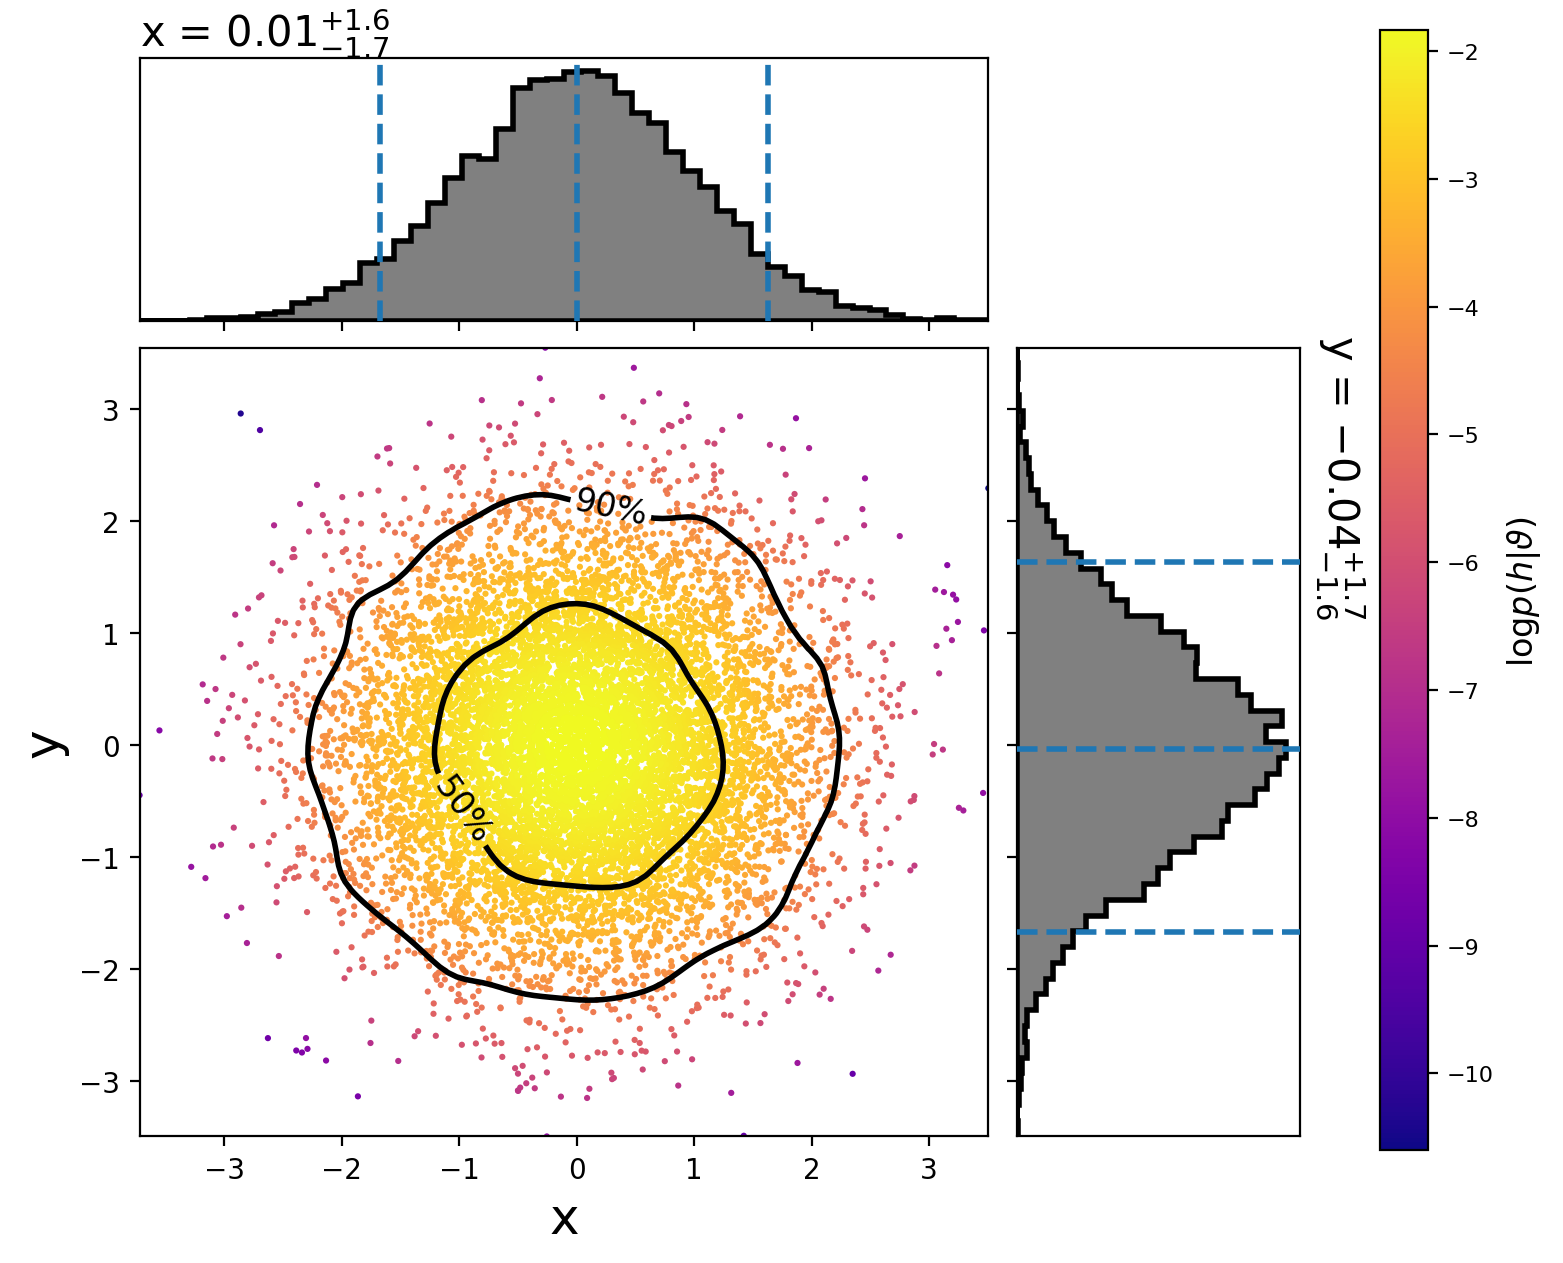

In [5]:
Image(filename="posterior-normal2d.png", width=640, height=480)

The scatter points show each walker's position after the last iteration. The
points are colored by the log likelihood at that point, with the 50th and 90th
percentile contours drawn.

#### Alternatively, we can create a density plot of the posterior:

In [6]:
!pycbc_inference_plot_posterior --verbose \
        --input-file normal2d.hdf \
        --output-file density-normal2d.png \
        --parameters x y \
        --plot-density \
        --plot-contours \
        --plot-marginal

2020-03-03 18:26:46,979 Reading input file normal2d.hdf
2020-03-03 18:26:46,981 Loading samples
2020-03-03 18:26:46,994 Loaded 10000 samples
2020-03-03 18:26:46,994 Plotting
2020-03-03 18:26:51,884 Done


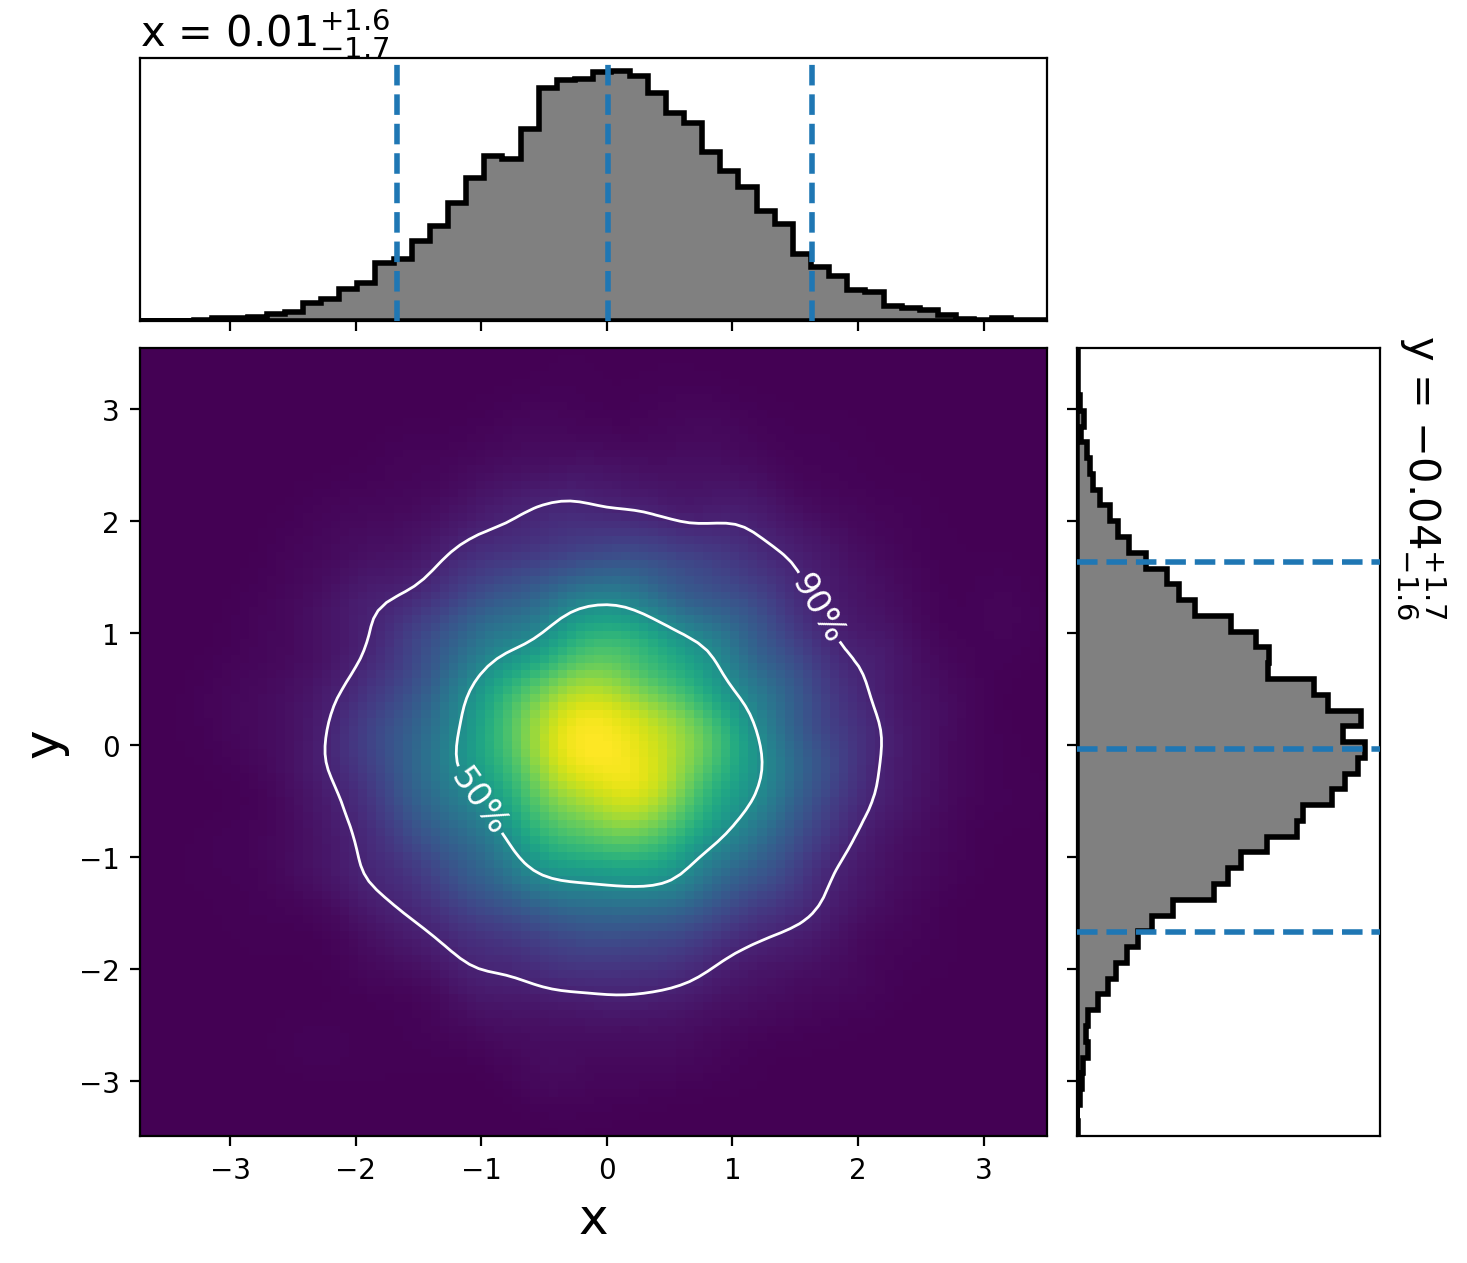

In [7]:
Image(filename="density-normal2d.png", width=640, height=480)

## 4. Diagnostic plots (MCMC)

### The autocorrelation function

The program `pycbc_inference_plot_acf` averages each parameter chain over all of the walkers, then calculates the [autocorrelation function](http://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.autocorrelation.calculate_acf) (ACF) and plots it. By default, the autocorrelation function is only calculated over the iterations post burn-in (in this case, the second half of the chains).

In [8]:
!pycbc_inference_plot_acf --input-file normal2d.hdf \
    --output-file plotacf.png \
    --parameters x y \
    --verbose

2020-03-03 18:26:54,399 Loading parameters
2020-03-03 18:26:54,399 Reading input file normal2d.hdf
2020-03-03 18:26:54,401 Calculating autocorrelation functions
2020-03-03 18:26:54,727 Plotting autocorrelation functions
2020-03-03 18:26:54,744 Parameter x
2020-03-03 18:26:54,746 Parameter y
2020-03-03 18:26:55,015 Done


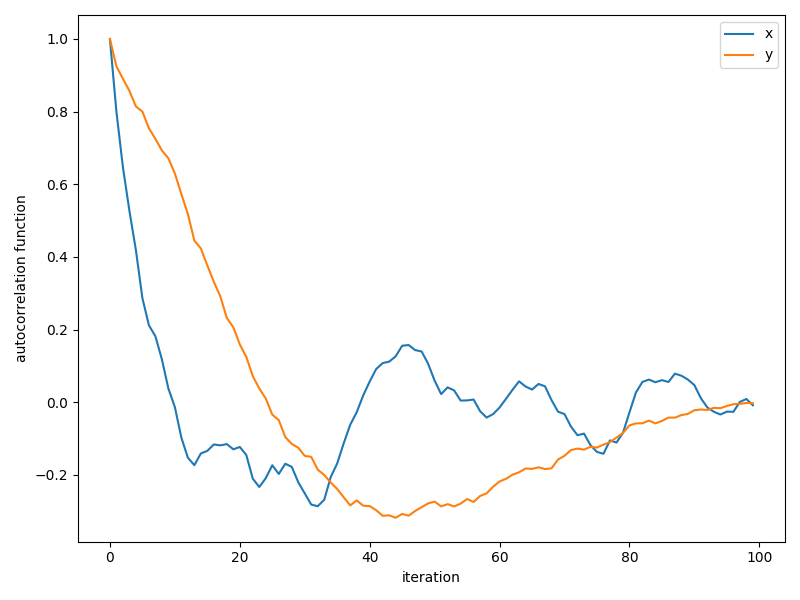

In [9]:
Image(filename="plotacf.png", width=640, height=480)

### The autocorrelation time

The program `pycbc_inference_plot_acl` calculates and plots the [autocorrelation length](http://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.autocorrelation.calculate_acl) (ACL) of each walker separately and histograms the result.

In [10]:
!pycbc_inference_plot_acl --input-file normal2d.hdf \
    --output-file plotacl.png \
    --verbose

2020-03-03 18:26:57,500 Reading input file normal2d.hdf
2020-03-03 18:26:57,502 Calculating autocorrelation length
2020-03-03 18:27:00,506 Plotting autocorrelation times
2020-03-03 18:27:03,212 Plotting autocorrelation times
2020-03-03 18:27:03,396 Done


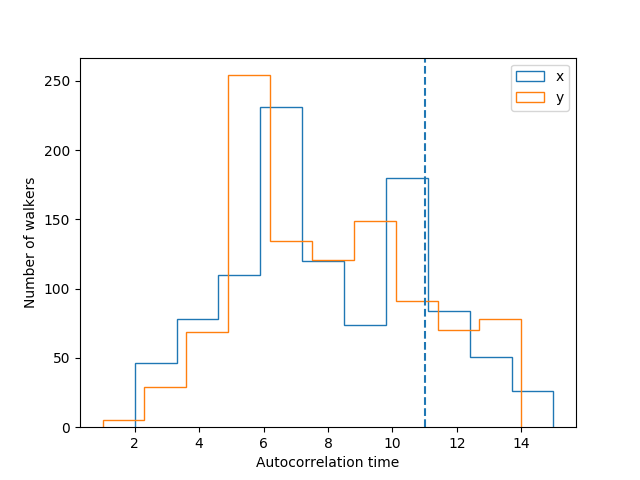

In [11]:
Image(filename="plotacl.png", width=640, height=480)

### Chain plots

The program `pycbc_inference_plot_samples` will plot each parameter as a function of iteration.

Note that we provide `--thin-start 0` and `--thin-interval 1` arguments. This is so we can see the entire chain, with every iteration plotted. Without them, the program will read samples starting from the burn in iteration (in this case, the halfway point), thinned by the autocorrelation length. This is true of any program that has these `thin-start/thin-interval` options.

In [12]:
!pycbc_inference_plot_samples --verbose \
    --input-file normal2d.hdf \
    --output-file samples_chain.png \
    --parameters x y \
    --thin-start 0 \
    --thin-interval 1

2020-03-03 18:27:05,900 Reading input file normal2d.hdf
2020-03-03 18:27:05,902 Plotting samples
2020-03-03 18:27:10,850 Done


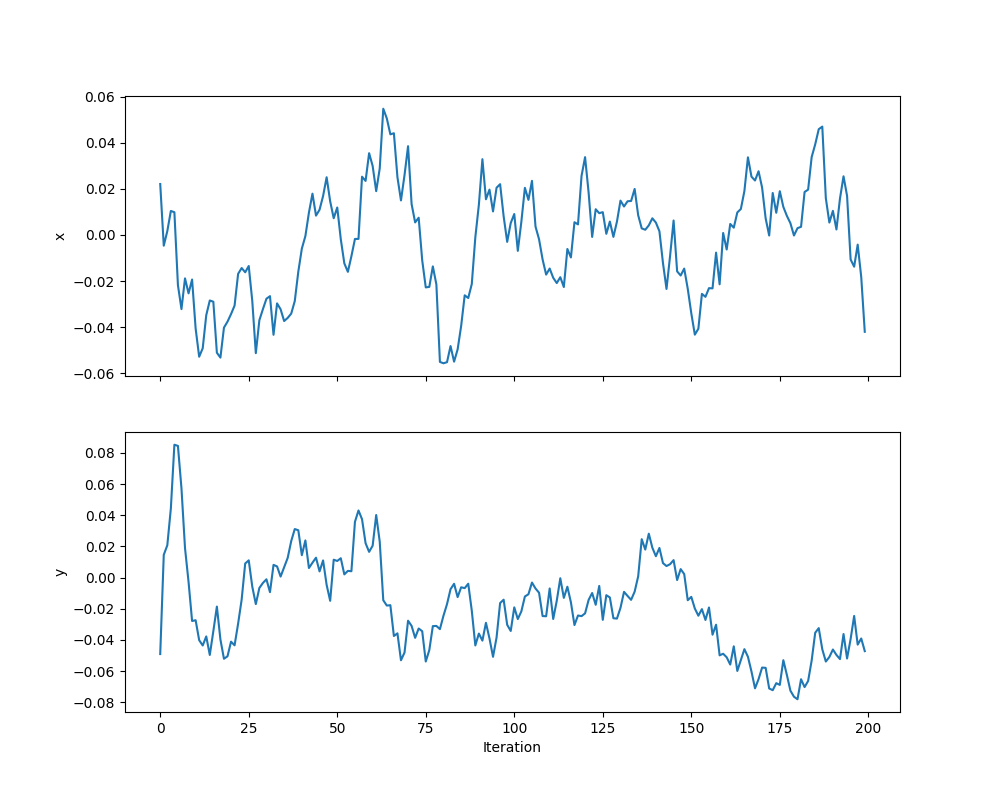

In [13]:
Image(filename="samples_chain.png", width=640, height=480)

By default, this program will average the chains over all of the walkers. This is why there was a single line. However, you can plot each walker separately by adding the option `--walkers all`. **Try it!**

### The acceptance rate

This plots the acceptance rate, which for `emcee` is the average number of proposals that were accepted for each walker (aka the [acceptance fraction](http://dfm.io/emcee/current/api/#emcee.EnsembleSampler.acceptance_fraction)).

*Note: for the `emcee` and `emcee_pt` samplers, the average is done over all iterations since the last checkpoint. Since we are using no checkpointing here (see the next tutorial for details on checkpointing), this is the average over all iterations.*

In [14]:
!pycbc_inference_plot_acceptance_rate --input-file normal2d.hdf \
    --output-file acceptance_rate.png \
    --verbose

2020-03-03 18:27:13,363 Reading input file
2020-03-03 18:27:13,366 Plotting acceptance fraction
2020-03-03 18:27:13,541 Done


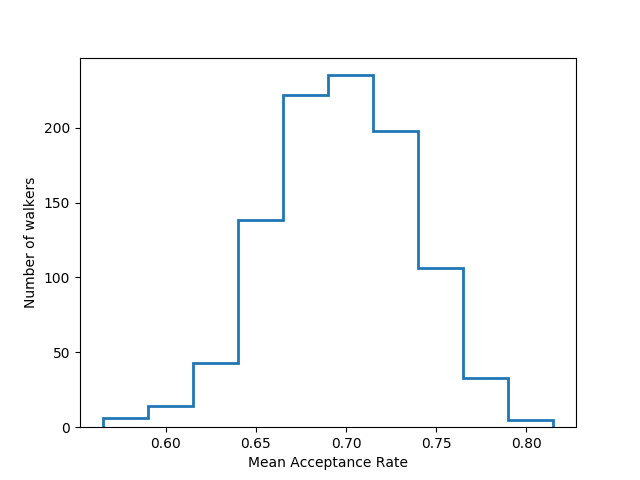

In [15]:
Image(filename="acceptance_rate.png", width=640, height=480)

### A movie of the results

We can use `pycbc_inference_plot_movie` to make a movie showing how each of the walkers evolved with time.

*Note: this requires `ffmpeg` to be installed if you were to run the following command.* We've included the output it would produce.

In [16]:
if False:
    !pycbc_inference_plot_movie --verbose \
        --nprocesses 4 \
        --input-file normal2d.hdf \
        --output-prefix frames-normal2d \
        --movie-file normal2d_mcmc_evolution.mp4 \
        --cleanup \
        --plot-scatter \
        --plot-contours \
        --plot-marginal \
        --z-arg 'loglikelihood:$\log p(h|\vartheta)$' \
        --frame-step 1

In [17]:
HTML("""
<video width="640" height="480" controls>
  <source src="normal2d_mcmc_evolution.mp4" type="video/mp4">
</video>
""")

## Other test distributions

Several other test models exist in the `pycbc.inference.models` package. They are the models that begin with `Test`. The full list:

|Name                   |Class                                                     |
|-----------------------|----------------------------------------------------------|
| ``'test_eggbox'``     | [TestEggbox](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.analytic.TestEggbox) |
| ``'test_normal'``     | [TestNormal](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.analytic.TestNormal) |
| ``'test_prior'``      | [TestPrior](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.analytic.TestPrior) |
| ``'test_rosenbrock'`` | [TestRosenbrock](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.analytic.TestRosenbrock) |
| ``'test_volcano'``    | [TestVolcano](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.analytic.TestVolcano) |


## Challenges:
 1. Repeat the above analysis, but test on a 3D Rosenbrock distribution using the [TestRosenbrock](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.analytic.TestRosenbrock) model. Call the third variable `z`, and set its prior to be uniform $\in [0, 10)$. Change the name of the output file so as not to overwrite your previous results.

 2. Repeat the 3D Rosenbrock challenge, but using `emcee_pt` as the sampler. Use 4 temperatures.